# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-io matplotlib

## 1.2 Load Dependencies

In [32]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [33]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [34]:
import tensorflow_io as tfio

In [35]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [36]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

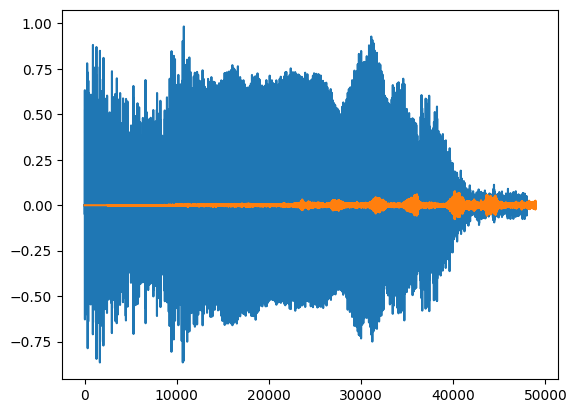

In [37]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [38]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [39]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [40]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [41]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [42]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [43]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [44]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [45]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [46]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [47]:
spectrogram, label = preprocess(filepath, label)

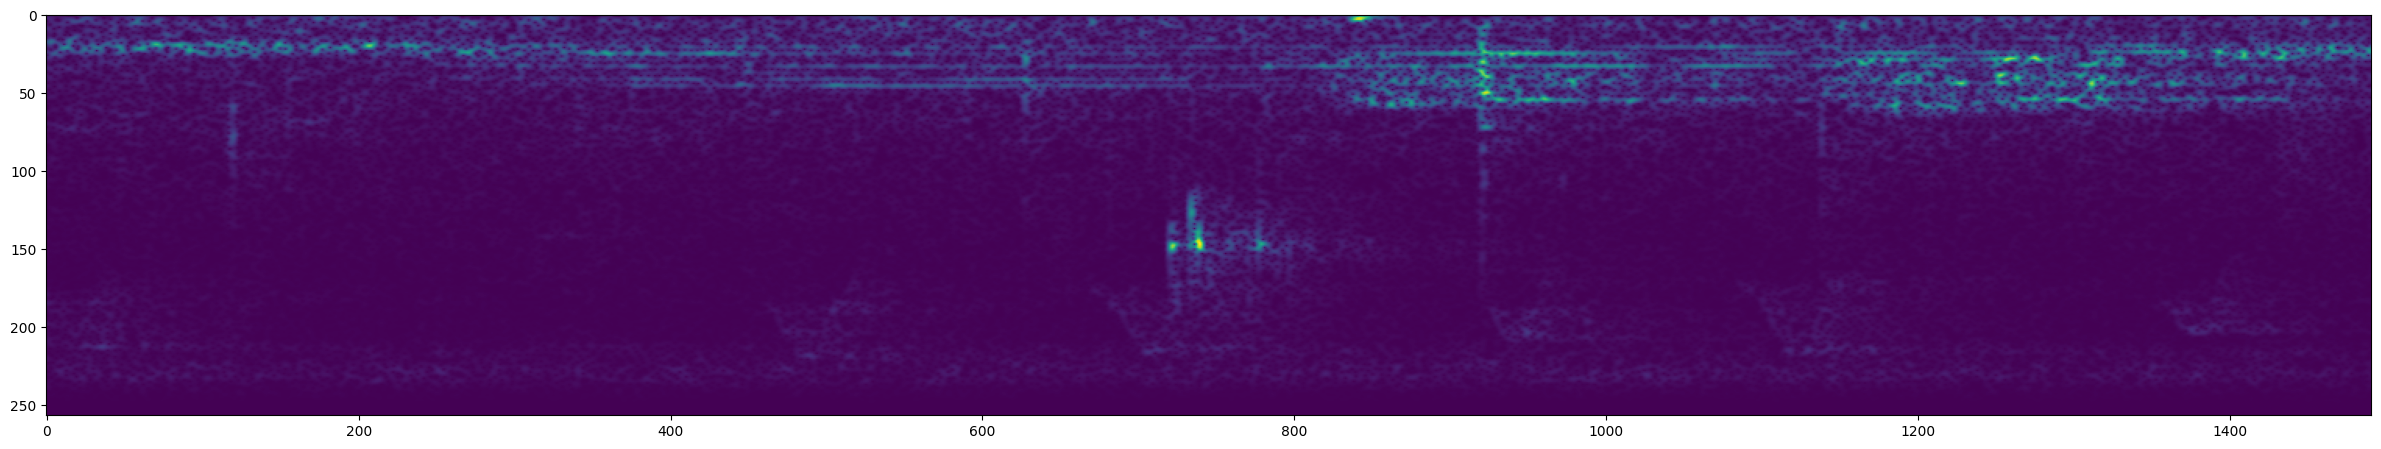

In [48]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [49]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [50]:
len(data)

51

In [51]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [52]:
samples, labels = train.as_numpy_iterator().next()

In [53]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(1491, 257, 1)))  
model.add(MaxPooling2D((2, 2)))  # Add pooling to reduce dimensionality
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2))) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1489, 255, 8)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 8)      0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 742, 125, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 8)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 184016)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

## 7.3 Fit Model, View Loss and KPI Plots

In [61]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 11s 131ms/step - loss: 0.7232 - recall: 0.8854 - precision: 0.8742 - val_loss: 0.0846 - val_recall: 0.9733 - val_precision: 0.9359
Epoch 2/4
36/36 [==============================] - 4s 117ms/step - loss: 0.0453 - recall: 0.9434 - precision: 0.9868 - val_loss: 0.0360 - val_recall: 0.9444 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 4s 117ms/step - loss: 0.0178 - recall: 0.9867 - precision: 1.0000 - val_loss: 0.0062 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 4s 117ms/step - loss: 0.0110 - recall: 0.9870 - precision: 0.9935 - val_loss: 0.0080 - val_recall: 0.9848 - val_precision: 1.0000


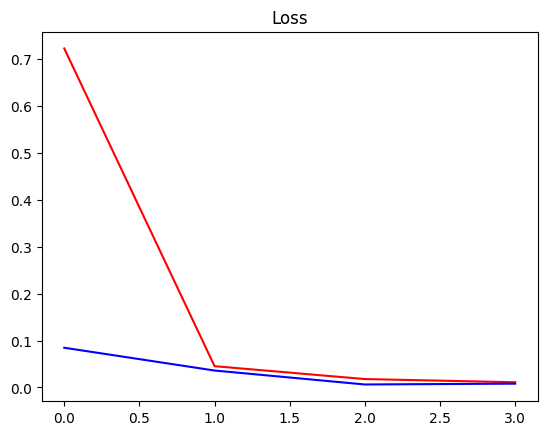

In [62]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

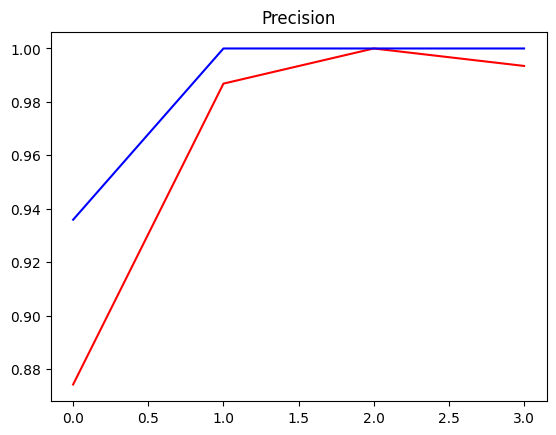

In [63]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

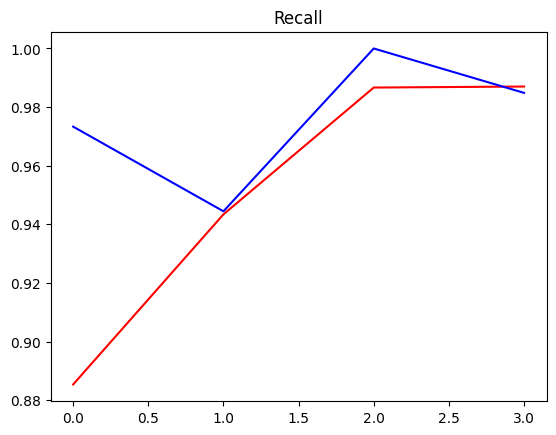

In [64]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [65]:
X_test, y_test = test.as_numpy_iterator().next()

In [66]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [67]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [68]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [69]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [70]:
wav = load_mp3_16k_mono(mp3)

In [71]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [72]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [73]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [76]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [77]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [78]:
from itertools import groupby

In [79]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [80]:
calls

5

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [82]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(16)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [83]:
results

{'recording_00.mp3': array([[1.6915746e-02],
        [5.6408118e-03],
        [5.3570317e-03],
        [9.9600071e-01],
        [1.0000000e+00],
        [3.6729381e-03],
        [8.5330354e-03],
        [1.7324595e-02],
        [5.5068606e-03],
        [1.9464692e-02],
        [8.2815001e-03],
        [7.5402968e-03],
        [9.7474800e-03],
        [9.9999988e-01],
        [1.0000000e+00],
        [7.2868941e-03],
        [8.7717293e-05],
        [3.7694406e-03],
        [1.3849541e-02],
        [3.9492514e-02],
        [1.9039910e-02],
        [9.9309040e-03],
        [5.4945040e-02],
        [9.7184730e-01],
        [1.0000000e+00],
        [1.1804568e-03],
        [9.4923249e-04],
        [2.4736319e-02],
        [3.8988201e-03],
        [3.1227289e-02],
        [6.7840051e-03],
        [6.4551488e-02],
        [1.8572596e-01],
        [3.2115839e-02],
        [4.4235066e-02],
        [2.3991857e-02],
        [1.0000000e+00],
        [2.4180664e-03],
        [2.1244626e-02],
     

## 10.2 Convert Predictions into Classes

In [84]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [85]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 2,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 3,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 6,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 3,
 'recording_40.mp3': 1,
 'recording_41.

# 11. Export Results

In [86]:
import csv

In [87]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])